# Cluster Analysis of Trimmed Spectrogram (CATS)

In [1]:
import numpy as np
import numba as nb
import holoviews as hv
# hv.extension('bokeh')

from scipy import signal, special, optimize, stats
import ssqueezepy as ssq
import timeit
import xarray as xr

In [2]:
import pyskbel as api
import cats

# Synthetic data

In [3]:
N_datasets = 25

# i = np.random.choice(N_datasets)
i = 2
folder = "C:/Users/seraf/OneDrive - ualberta.ca/Documents/WaveDatasets/GeneratedData"
Dclean = api.compose_from_meta(f"{folder}/MetaDataSetsNew/dataset_{i}_main.pkl", 
                               noise=0.0, data_path=f'{folder}/SurfaceEvents')
main_meta = api.utils.read_dict(f"{folder}/MetaDataSetsNew/dataset_{i}_main.pkl")
main_meta['data_path'] = 'C:\\Users\\seraf\\OneDrive - ualberta.ca\\Documents\\WaveDatasets\\GeneratedData\\SurfaceEvents'

x = np.linspace(main_meta['xmin'], main_meta['xmax'], main_meta['nx'])
time = np.linspace(main_meta['Tmin'], main_meta['Tmax'], main_meta['nT'])
dt = main_meta['dt']

Cdim = 0
Dclean = np.moveaxis(Dclean, -1, Cdim)
main_dims = ["Location", "Time"]
main_dims.insert(Cdim, "Component")

t1, t2 = 8, 22
it1, it2 = int(t1 / dt), int(t2 / dt)
time = time[it1 : it2 + 1]
time -= time.min()
Dclean = Dclean[..., it1 : it2 + 1]

Taper on axis = -2 is applied


  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
beta = 1
noise_ids = {-1 : "high_freq", 0 : "white", 1 : "low_freq"}
noise_id = noise_ids[beta]
Noise = api.utils.get_noise((0.05, beta), Dclean.shape, axis=2)
Noise += 0.07 * np.sin(time * 2 * np.pi * 50)[None, None, :]
D = Dclean + Noise

eps = 0.007
true_detection_time = abs(Dclean) > eps
Srms = np.sqrt(np.mean(Dclean[true_detection_time]**2))
Nrms = np.sqrt(np.mean(Noise**2))
print("SNR = ", Srms**2 / Nrms**2)
print("Noise color = ", noise_id)

SNR =  1.0310220383391009
Noise color =  low_freq


In [21]:
catsden = cats.CATSDenoiser(dt_sec=dt,
                            stft_window_sec=('hann', 0.15),
                            stft_overlap=0.5,
                            stft_nfft=512,
                            minSNR=4.5,
                            stationary_frame_sec=1.0,
                            cluster_size_t_sec=0.3,
                            cluster_size_f_Hz=4.,
                            cluster_distance_t_sec=None,
                            cluster_distance_f_Hz=None,
                            min_neighbors=None,
                            clustering_with_SNR=True,
                            clustering_multitrace=True,
                            cluster_size_trace=3,
                            cluster_distance_trace=2,
                            stft_backend='ssqueezepy')
print(f"{catsden.cluster_distance_t_len = }")
print(f"{catsden.cluster_distance_f_len = }")

catsden.cluster_distance_t_len = 2
catsden.cluster_distance_f_len = 2


In [22]:
%time denres = catsden.denoise(D)

CPU times: total: 4.75 s
Wall time: 3.94 s


:Layout
   .Curve.A_0_full_stop_Input_data_colon_x_n                                                                                                                                                                                     :Curve   [Time]   (Amplitude)
   .Image.A_1_full_stop_Spectrogram_colon_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line                                                                                                         :Image   [Time,Frequency]   (z)
   .Image.A_2_full_stop_Trimming_by_B_hyphen_minus_E_hyphen_minus_DATE_colon_B_left_curly_bracket_k_comma_m_right_curly_bracket_reverse_over_cdot_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line :Image   [Time,Frequency]   (z)
   .Image.A_3_full_stop_Clustering_colon_C_left_curly_bracket_k_comma_m_right_curly_bracket_reverse_over_cdot_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line                                     :Image   [Time,Frequency]   (z)
   .Image.A_4_full_stop_Filling_colon_F_left_curly_bracket_k_comma_m_right_curly_bracket_reverse_over_cdot_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line                                        :Image   [Time,Frequency]   (z)
   .Curve.A_5_full_stop_Denoised_signal_colon_y_n                                                                                                                                                                                :Curve   [Time]   (Amplitude)
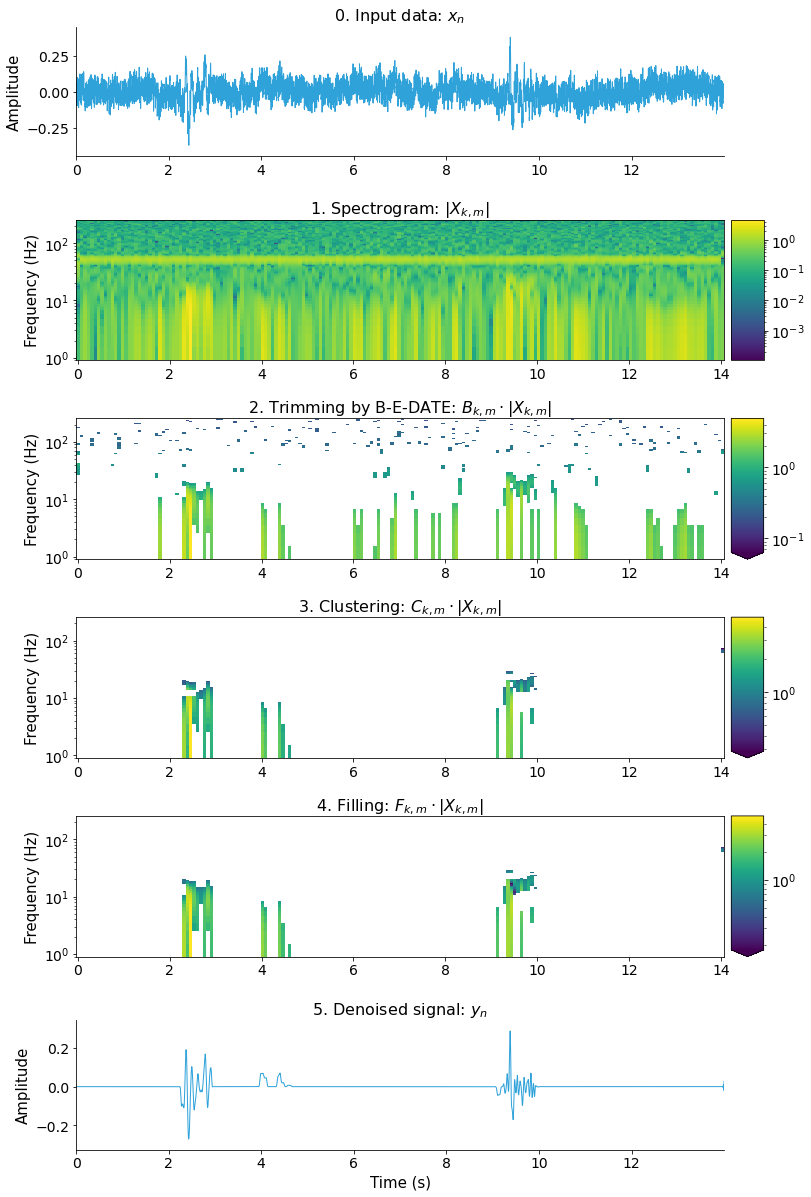

In [23]:
comp = 'Z'
comps = {'X' : 0, 'Y' : 1, 'Z': 2}
ind = [63]
ind.insert(Cdim, comps[comp])
ind = tuple(ind)
fig = denres.plot(ind).cols(1)
xlim = (np.nan, np.nan)
fig.opts(hv.opts.Curve(xlim=xlim, linewidth=1), 
         hv.opts.Image(xlim=xlim, logz=True, ylim=(0.9, np.nan)))
# hv.save(fig, f'../figures/denoise_synthetic_demo_{comp}_{noise_id}.png', dpi=300)
fig

:Overlay
   .Curve.A_0_full_stop_Input_data_colon_x_n      :Curve   [Time]   (Amplitude)
   .Curve.A_5_full_stop_Denoised_signal_colon_y_n :Curve   [Time]   (Amplitude)
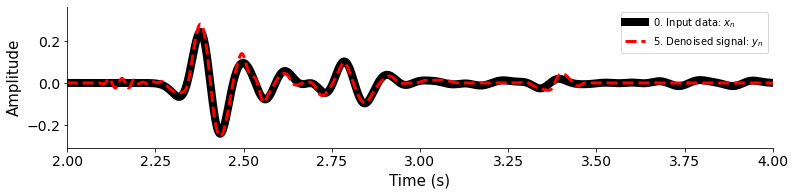

In [14]:
fig_new = denres.plot(ind)
fig_new[0].data.Amplitude = Dclean[ind]
fig_new[0].opts(xlim=(2, 4), xlabel='Time (s)', color='k',
                linewidth=8, fig_size=350) * fig[-1].opts(linewidth=3, color='red', 
                                                          linestyle='--')
# hv.save(fig[0], f"figures/CleanZ.png", dpi=300)

In [24]:
data_meta = dict(dims=main_dims, 
                 coords={"Component" : ['X', 'Y', 'Z'],
                         "Location" : x,
                         "Time" : time})

traces = {'Synthetic' : xr.DataArray(D, **data_meta)}
traces_clean = {'Synthetic' : xr.DataArray(Dclean, **data_meta)}
traces_denoised = {'Synthetic' : xr.DataArray(denres.denoised_signal, **data_meta)}

:Overlay
   .Curve.I        :Curve   [Time]   (y)
   .Curve.II       :Curve   [Time]   (y)
   .Curve.III      :Curve   [Time]   (y)
   .Curve.IV       :Curve   [Time]   (y)
   .Curve.V        :Curve   [Time]   (y)
   .Curve.VI       :Curve   [Time]   (y)
   .Curve.VII      :Curve   [Time]   (y)
   .Curve.VIII     :Curve   [Time]   (y)
   .Curve.IX       :Curve   [Time]   (y)
   .Curve.X        :Curve   [Time]   (y)
   .Curve.XI       :Curve   [Time]   (y)
   .Curve.XII      :Curve   [Time]   (y)
   .Curve.XIII     :Curve   [Time]   (y)
   .Curve.XIV      :Curve   [Time]   (y)
   .Curve.XV       :Curve   [Time]   (y)
   .Curve.XVI      :Curve   [Time]   (y)
   .Curve.XVII     :Curve   [Time]   (y)
   .Curve.XVIII    :Curve   [Time]   (y)
   .Curve.XIX      :Curve   [Time]   (y)
   .Curve.XX       :Curve   [Time]   (y)
   .Curve.XXI      :Curve   [Time]   (y)
   .Curve.XXII     :Curve   [Time]   (y)
   .Curve.XXIII    :Curve   [Time]   (y)
   .Curve.XXIV     :Curve   [Time]   (y)
   .Curve.XXV      :Curve   [Time]   (y)
   .Curve.XXVI     :Curve   [Time]   (y)
   .Curve.XXVII    :Curve   [Time]   (y)
   .Curve.XXVIII   :Curve   [Time]   (y)
   .Curve.XXIX     :Curve   [Time]   (y)
   .Curve.XXX      :Curve   [Time]   (y)
   .Curve.XXXI     :Curve   [Time]   (y)
   .Curve.XXXII    :Curve   [Time]   (y)
   .Curve.XXXIII   :Curve   [Time]   (y)
   .Curve.XXXIV    :Curve   [Time]   (y)
   .Curve.XXXV     :Curve   [Time]   (y)
   .Curve.XXXVI    :Curve   [Time]   (y)
   .Curve.XXXVII   :Curve   [Time]   (y)
   .Curve.XXXVIII  :Curve   [Time]   (y)
   .Curve.XXXIX    :Curve   [Time]   (y)
   .Curve.XL       :Curve   [Time]   (y)
   .Curve.XLI      :Curve   [Time]   (y)
   .Curve.XLII     :Curve   [Time]   (y)
   .Curve.XLIII    :Curve   [Time]   (y)
   .Curve.XLIV     :Curve   [Time]   (y)
   .Curve.XLV      :Curve   [Time]   (y)
   .Curve.XLVI     :Curve   [Time]   (y)
   .Curve.XLVII    :Curve   [Time]   (y)
   .Curve.XLVIII   :Curve   [Time]   (y)
   .Curve.XLIX     :Curve   [Time]   (y)
   .Curve.L        :Curve   [Time]   (y)
   .Curve.LI       :Curve   [Time]   (y)
   .Curve.LII      :Curve   [Time]   (y)
   .Curve.LIII     :Curve   [Time]   (y)
   .Curve.LIV      :Curve   [Time]   (y)
   .Curve.LV       :Curve   [Time]   (y)
   .Curve.LVI      :Curve   [Time]   (y)
   .Curve.LVII     :Curve   [Time]   (y)
   .Curve.LVIII    :Curve   [Time]   (y)
   .Curve.LIX      :Curve   [Time]   (y)
   .Curve.LX       :Curve   [Time]   (y)
   .Curve.LXI      :Curve   [Time]   (y)
   .Curve.LXII     :Curve   [Time]   (y)
   .Curve.LXIII    :Curve   [Time]   (y)
   .Curve.LXIV     :Curve   [Time]   (y)
   .Curve.LXV      :Curve   [Time]   (y)
   .Curve.LXVI     :Curve   [Time]   (y)
   .Curve.LXVII    :Curve   [Time]   (y)
   .Curve.LXVIII   :Curve   [Time]   (y)
   .Curve.LXIX     :Curve   [Time]   (y)
   .Curve.LXX      :Curve   [Time]   (y)
   .Curve.LXXI     :Curve   [Time]   (y)
   .Curve.LXXII    :Curve   [Time]   (y)
   .Curve.LXXIII   :Curve   [Time]   (y)
   .Curve.LXXIV    :Curve   [Time]   (y)
   .Curve.LXXV     :Curve   [Time]   (y)
   .Curve.LXXVI    :Curve   [Time]   (y)
   .Curve.LXXVII   :Curve   [Time]   (y)
   .Curve.LXXVIII  :Curve   [Time]   (y)
   .Curve.LXXIX    :Curve   [Time]   (y)
   .Curve.LXXX     :Curve   [Time]   (y)
   .Curve.LXXXI    :Curve   [Time]   (y)
   .Curve.LXXXII   :Curve   [Time]   (y)
   .Curve.LXXXIII  :Curve   [Time]   (y)
   .Curve.LXXXIV   :Curve   [Time]   (y)
   .Curve.LXXXV    :Curve   [Time]   (y)
   .Curve.LXXXVI   :Curve   [Time]   (y)
   .Curve.LXXXVII  :Curve   [Time]   (y)
   .Curve.LXXXVIII :Curve   [Time]   (y)
   .Curve.LXXXIX   :Curve   [Time]   (y)
   .Curve.XC       :Curve   [Time]   (y)
   .Curve.XCI      :Curve   [Time]   (y)
   .Curve.XCII     :Curve   [Time]   (y)
   .Curve.XCIII    :Curve   [Time]   (y)
   .Curve.XCIV     :Curve   [Time]   (y)
   .Curve.XCV      :Curve   [Time]   (y)
   .Curve.XCVI     :Curve   [Time]   (y)
   .Curve.XCVII    :Curve   [Time]   (y)
   .Curve.XCVI
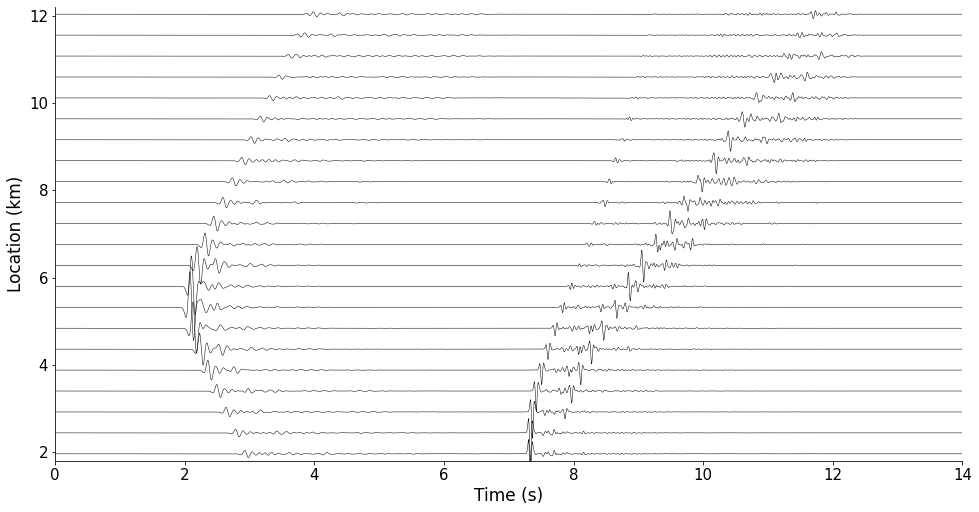

In [17]:
fname = 'Synthetic'

fig = cats.plot_traces(traces_clean, None, fname, comp, gain=0.75, rsp=6, alpha=0.2)
fontsize = dict(labels=17, ticks=15)
figsize = 450
fig = fig.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=2, fig_size=figsize, invert_axes=False,
                                                        ylabel='Location (km)', xlabel='Time (s)', 
                                                       )
# hv.save(fig, f'../figures/denoise_synthetic_clean_{fname}_{comp}.png', dpi=300)
fig

:Overlay
   .Curve.I        :Curve   [Time]   (y)
   .Curve.II       :Curve   [Time]   (y)
   .Curve.III      :Curve   [Time]   (y)
   .Curve.IV       :Curve   [Time]   (y)
   .Curve.V        :Curve   [Time]   (y)
   .Curve.VI       :Curve   [Time]   (y)
   .Curve.VII      :Curve   [Time]   (y)
   .Curve.VIII     :Curve   [Time]   (y)
   .Curve.IX       :Curve   [Time]   (y)
   .Curve.X        :Curve   [Time]   (y)
   .Curve.XI       :Curve   [Time]   (y)
   .Curve.XII      :Curve   [Time]   (y)
   .Curve.XIII     :Curve   [Time]   (y)
   .Curve.XIV      :Curve   [Time]   (y)
   .Curve.XV       :Curve   [Time]   (y)
   .Curve.XVI      :Curve   [Time]   (y)
   .Curve.XVII     :Curve   [Time]   (y)
   .Curve.XVIII    :Curve   [Time]   (y)
   .Curve.XIX      :Curve   [Time]   (y)
   .Curve.XX       :Curve   [Time]   (y)
   .Curve.XXI      :Curve   [Time]   (y)
   .Curve.XXII     :Curve   [Time]   (y)
   .Curve.XXIII    :Curve   [Time]   (y)
   .Curve.XXIV     :Curve   [Time]   (y)
   .Curve.XXV      :Curve   [Time]   (y)
   .Curve.XXVI     :Curve   [Time]   (y)
   .Curve.XXVII    :Curve   [Time]   (y)
   .Curve.XXVIII   :Curve   [Time]   (y)
   .Curve.XXIX     :Curve   [Time]   (y)
   .Curve.XXX      :Curve   [Time]   (y)
   .Curve.XXXI     :Curve   [Time]   (y)
   .Curve.XXXII    :Curve   [Time]   (y)
   .Curve.XXXIII   :Curve   [Time]   (y)
   .Curve.XXXIV    :Curve   [Time]   (y)
   .Curve.XXXV     :Curve   [Time]   (y)
   .Curve.XXXVI    :Curve   [Time]   (y)
   .Curve.XXXVII   :Curve   [Time]   (y)
   .Curve.XXXVIII  :Curve   [Time]   (y)
   .Curve.XXXIX    :Curve   [Time]   (y)
   .Curve.XL       :Curve   [Time]   (y)
   .Curve.XLI      :Curve   [Time]   (y)
   .Curve.XLII     :Curve   [Time]   (y)
   .Curve.XLIII    :Curve   [Time]   (y)
   .Curve.XLIV     :Curve   [Time]   (y)
   .Curve.XLV      :Curve   [Time]   (y)
   .Curve.XLVI     :Curve   [Time]   (y)
   .Curve.XLVII    :Curve   [Time]   (y)
   .Curve.XLVIII   :Curve   [Time]   (y)
   .Curve.XLIX     :Curve   [Time]   (y)
   .Curve.L        :Curve   [Time]   (y)
   .Curve.LI       :Curve   [Time]   (y)
   .Curve.LII      :Curve   [Time]   (y)
   .Curve.LIII     :Curve   [Time]   (y)
   .Curve.LIV      :Curve   [Time]   (y)
   .Curve.LV       :Curve   [Time]   (y)
   .Curve.LVI      :Curve   [Time]   (y)
   .Curve.LVII     :Curve   [Time]   (y)
   .Curve.LVIII    :Curve   [Time]   (y)
   .Curve.LIX      :Curve   [Time]   (y)
   .Curve.LX       :Curve   [Time]   (y)
   .Curve.LXI      :Curve   [Time]   (y)
   .Curve.LXII     :Curve   [Time]   (y)
   .Curve.LXIII    :Curve   [Time]   (y)
   .Curve.LXIV     :Curve   [Time]   (y)
   .Curve.LXV      :Curve   [Time]   (y)
   .Curve.LXVI     :Curve   [Time]   (y)
   .Curve.LXVII    :Curve   [Time]   (y)
   .Curve.LXVIII   :Curve   [Time]   (y)
   .Curve.LXIX     :Curve   [Time]   (y)
   .Curve.LXX      :Curve   [Time]   (y)
   .Curve.LXXI     :Curve   [Time]   (y)
   .Curve.LXXII    :Curve   [Time]   (y)
   .Curve.LXXIII   :Curve   [Time]   (y)
   .Curve.LXXIV    :Curve   [Time]   (y)
   .Curve.LXXV     :Curve   [Time]   (y)
   .Curve.LXXVI    :Curve   [Time]   (y)
   .Curve.LXXVII   :Curve   [Time]   (y)
   .Curve.LXXVIII  :Curve   [Time]   (y)
   .Curve.LXXIX    :Curve   [Time]   (y)
   .Curve.LXXX     :Curve   [Time]   (y)
   .Curve.LXXXI    :Curve   [Time]   (y)
   .Curve.LXXXII   :Curve   [Time]   (y)
   .Curve.LXXXIII  :Curve   [Time]   (y)
   .Curve.LXXXIV   :Curve   [Time]   (y)
   .Curve.LXXXV    :Curve   [Time]   (y)
   .Curve.LXXXVI   :Curve   [Time]   (y)
   .Curve.LXXXVII  :Curve   [Time]   (y)
   .Curve.LXXXVIII :Curve   [Time]   (y)
   .Curve.LXXXIX   :Curve   [Time]   (y)
   .Curve.XC       :Curve   [Time]   (y)
   .Curve.XCI      :Curve   [Time]   (y)
   .Curve.XCII     :Curve   [Time]   (y)
   .Curve.XCIII    :Curve   [Time]   (y)
   .Curve.XCIV     :Curve   [Time]   (y)
   .Curve.XCV      :Curve   [Time]   (y)
   .Curve.XCVI     :Curve   [Time]   (y)
   .Curve.XCVII    :Curve   [Time]   (y)
   .Curve.XCVI
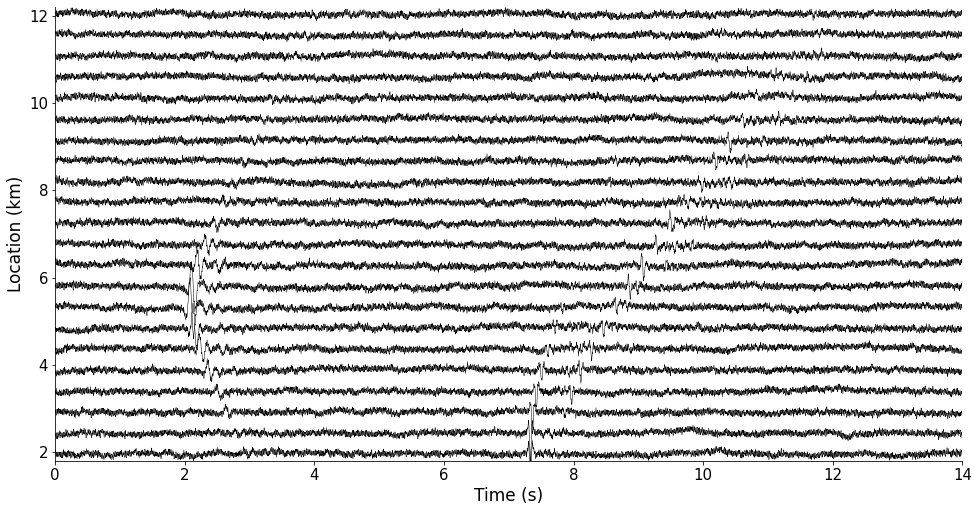

In [26]:
fig = cats.plot_traces(traces, None, fname, comp, gain=0.75, rsp=6, alpha=0.2)
fontsize = dict(labels=17, ticks=15)
figsize = 450
fig = fig.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=2, fig_size=figsize, invert_axes=False,
                                                        ylabel='Location (km)', xlabel='Time (s)')
# hv.save(fig, f'../figures/denoise_synthetic_noisy_{fname}_{comp}_{noise_id}.png', dpi=300)
fig

:Overlay
   .Curve.I        :Curve   [Time]   (y)
   .Curve.II       :Curve   [Time]   (y)
   .Curve.III      :Curve   [Time]   (y)
   .Curve.IV       :Curve   [Time]   (y)
   .Curve.V        :Curve   [Time]   (y)
   .Curve.VI       :Curve   [Time]   (y)
   .Curve.VII      :Curve   [Time]   (y)
   .Curve.VIII     :Curve   [Time]   (y)
   .Curve.IX       :Curve   [Time]   (y)
   .Curve.X        :Curve   [Time]   (y)
   .Curve.XI       :Curve   [Time]   (y)
   .Curve.XII      :Curve   [Time]   (y)
   .Curve.XIII     :Curve   [Time]   (y)
   .Curve.XIV      :Curve   [Time]   (y)
   .Curve.XV       :Curve   [Time]   (y)
   .Curve.XVI      :Curve   [Time]   (y)
   .Curve.XVII     :Curve   [Time]   (y)
   .Curve.XVIII    :Curve   [Time]   (y)
   .Curve.XIX      :Curve   [Time]   (y)
   .Curve.XX       :Curve   [Time]   (y)
   .Curve.XXI      :Curve   [Time]   (y)
   .Curve.XXII     :Curve   [Time]   (y)
   .Curve.XXIII    :Curve   [Time]   (y)
   .Curve.XXIV     :Curve   [Time]   (y)
   .Curve.XXV      :Curve   [Time]   (y)
   .Curve.XXVI     :Curve   [Time]   (y)
   .Curve.XXVII    :Curve   [Time]   (y)
   .Curve.XXVIII   :Curve   [Time]   (y)
   .Curve.XXIX     :Curve   [Time]   (y)
   .Curve.XXX      :Curve   [Time]   (y)
   .Curve.XXXI     :Curve   [Time]   (y)
   .Curve.XXXII    :Curve   [Time]   (y)
   .Curve.XXXIII   :Curve   [Time]   (y)
   .Curve.XXXIV    :Curve   [Time]   (y)
   .Curve.XXXV     :Curve   [Time]   (y)
   .Curve.XXXVI    :Curve   [Time]   (y)
   .Curve.XXXVII   :Curve   [Time]   (y)
   .Curve.XXXVIII  :Curve   [Time]   (y)
   .Curve.XXXIX    :Curve   [Time]   (y)
   .Curve.XL       :Curve   [Time]   (y)
   .Curve.XLI      :Curve   [Time]   (y)
   .Curve.XLII     :Curve   [Time]   (y)
   .Curve.XLIII    :Curve   [Time]   (y)
   .Curve.XLIV     :Curve   [Time]   (y)
   .Curve.XLV      :Curve   [Time]   (y)
   .Curve.XLVI     :Curve   [Time]   (y)
   .Curve.XLVII    :Curve   [Time]   (y)
   .Curve.XLVIII   :Curve   [Time]   (y)
   .Curve.XLIX     :Curve   [Time]   (y)
   .Curve.L        :Curve   [Time]   (y)
   .Curve.LI       :Curve   [Time]   (y)
   .Curve.LII      :Curve   [Time]   (y)
   .Curve.LIII     :Curve   [Time]   (y)
   .Curve.LIV      :Curve   [Time]   (y)
   .Curve.LV       :Curve   [Time]   (y)
   .Curve.LVI      :Curve   [Time]   (y)
   .Curve.LVII     :Curve   [Time]   (y)
   .Curve.LVIII    :Curve   [Time]   (y)
   .Curve.LIX      :Curve   [Time]   (y)
   .Curve.LX       :Curve   [Time]   (y)
   .Curve.LXI      :Curve   [Time]   (y)
   .Curve.LXII     :Curve   [Time]   (y)
   .Curve.LXIII    :Curve   [Time]   (y)
   .Curve.LXIV     :Curve   [Time]   (y)
   .Curve.LXV      :Curve   [Time]   (y)
   .Curve.LXVI     :Curve   [Time]   (y)
   .Curve.LXVII    :Curve   [Time]   (y)
   .Curve.LXVIII   :Curve   [Time]   (y)
   .Curve.LXIX     :Curve   [Time]   (y)
   .Curve.LXX      :Curve   [Time]   (y)
   .Curve.LXXI     :Curve   [Time]   (y)
   .Curve.LXXII    :Curve   [Time]   (y)
   .Curve.LXXIII   :Curve   [Time]   (y)
   .Curve.LXXIV    :Curve   [Time]   (y)
   .Curve.LXXV     :Curve   [Time]   (y)
   .Curve.LXXVI    :Curve   [Time]   (y)
   .Curve.LXXVII   :Curve   [Time]   (y)
   .Curve.LXXVIII  :Curve   [Time]   (y)
   .Curve.LXXIX    :Curve   [Time]   (y)
   .Curve.LXXX     :Curve   [Time]   (y)
   .Curve.LXXXI    :Curve   [Time]   (y)
   .Curve.LXXXII   :Curve   [Time]   (y)
   .Curve.LXXXIII  :Curve   [Time]   (y)
   .Curve.LXXXIV   :Curve   [Time]   (y)
   .Curve.LXXXV    :Curve   [Time]   (y)
   .Curve.LXXXVI   :Curve   [Time]   (y)
   .Curve.LXXXVII  :Curve   [Time]   (y)
   .Curve.LXXXVIII :Curve   [Time]   (y)
   .Curve.LXXXIX   :Curve   [Time]   (y)
   .Curve.XC       :Curve   [Time]   (y)
   .Curve.XCI      :Curve   [Time]   (y)
   .Curve.XCII     :Curve   [Time]   (y)
   .Curve.XCIII    :Curve   [Time]   (y)
   .Curve.XCIV     :Curve   [Time]   (y)
   .Curve.XCV      :Curve   [Time]   (y)
   .Curve.XCVI     :Curve   [Time]   (y)
   .Curve.XCVII    :Curve   [Time]   (y)
   .Curve.XCVI
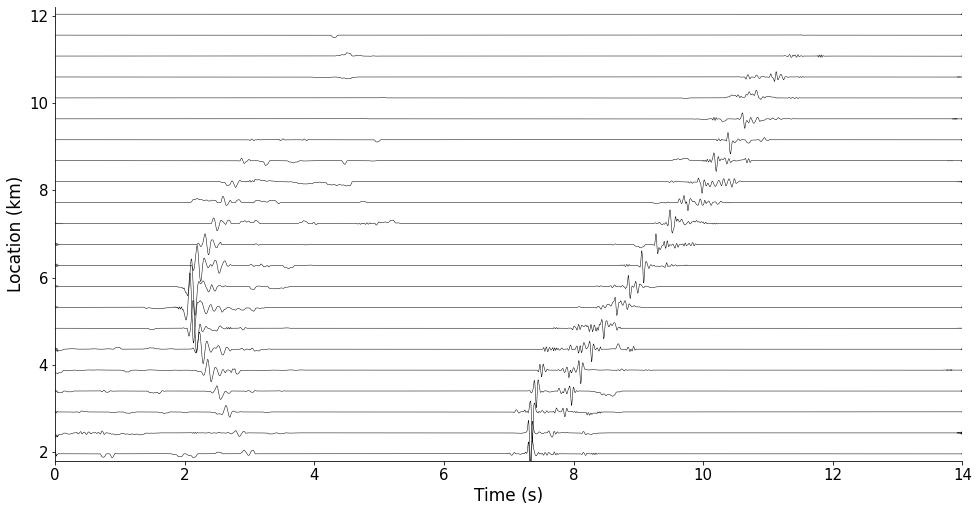

In [25]:
fig = cats.plot_traces(traces_denoised, None, fname, comp, gain=0.75, rsp=6, alpha=0.2)
fontsize = dict(labels=17, ticks=15)
figsize = 450
fig = fig.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=2, fig_size=figsize,
                                                        ylabel='Location (km)', xlabel='Time (s)')
# hv.save(fig, f'../figures/denoise_synthetic_denoised_{fname}_{comp}_{noise_id}.png', dpi=300)
fig

# Downhole data

In [27]:
import glob
from pathlib import Path
from scipy.io import loadmat, savemat, wavfile
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

In [28]:
data_dir = Path("C:/Users/seraf/OneDrive - ualberta.ca/Documents/SampleData")
data_folder = data_dir / 'BoreholeData_reformat'
data_paths = sorted(list(data_folder.rglob("*.pkl")))

In [42]:
filenames = []
Data = {}
Headers = {}

Cdim = 0
main_dims = ["Location", "Time"]
main_dims.insert(Cdim, "Component")

for i, fi in enumerate(tqdm(data_paths)):
    filename = fi.name.split('.')[0]
    filenames.append(filename)
    Di = api.utils.read_dict(fi)
    Headers[filename] = Di['hdrc']
    dt = Di['hdrc']['delta']
    time = np.arange(0, Di['data'].shape[-1] * dt, dt)
    Data[filename] = xr.DataArray(np.nan_to_num(Di['data']).swapaxes(0, Cdim), 
                                  dims=main_dims, 
                                  coords={"Component": ['X', 'Y', 'Z'], 
                                          "Location" : Di['hdrc']['stdp'], 
                                          "Time" : time})

  0%|          | 0/9 [00:00<?, ?it/s]

In [61]:
catsden = cats.CATSDenoiser(dt_sec=dt,
                            stft_window_sec=('hann', 0.1),
                            stft_overlap=0.75,
                            stft_nfft=512,
                            minSNR=4.5,
                            stationary_frame_sec=1.0,
                            cluster_size_t_sec=0.1,
                            cluster_size_f_Hz=35.,
                            cluster_distance_t_sec=None,
                            cluster_distance_f_Hz=None,
                            min_neighbors=None,
                            clustering_with_SNR=True,
                            clustering_multitrace=True,
                            cluster_size_trace=1,
                            cluster_distance_trace=2,
                            stft_backend='ssqueezepy')
print(f"{dt = }")
print(f"{catsden.stft_window_len = }")
print(f"{catsden.stft_nfft = }")
print(f"{catsden.stationary_frame_len = }")
print(f"{catsden.cluster_size_t_len = }")
print(f"{catsden.cluster_size_f_len = }")
print(f"{catsden.cluster_distance_t_len = }")
print(f"{catsden.cluster_distance_f_len = }")

dt = 0.00025
catsden.stft_window_len = 400
catsden.stft_nfft = 512
catsden.stationary_frame_len = 256
catsden.cluster_size_t_len = 4
catsden.cluster_size_f_len = 4
catsden.cluster_distance_t_len = 2
catsden.cluster_distance_f_len = 2


In [62]:
Denoised = {}
for fi, di in tqdm(Data.items()):
    denoised = catsden.denoise(di.values).denoised_signal
    Denoised[fi] = xr.DataArray(denoised, dims=di.dims,
                                coords={"Component" : di.coords["Component"],
                                        "Location" : di.coords["Location"],
                                        "Time" : di.coords["Time"]})

  0%|          | 0/9 [00:00<?, ?it/s]

:Overlay
   .Curve.I      :Curve   [Time]   (y)
   .Curve.II     :Curve   [Time]   (y)
   .Curve.III    :Curve   [Time]   (y)
   .Curve.IV     :Curve   [Time]   (y)
   .Curve.V      :Curve   [Time]   (y)
   .Curve.VI     :Curve   [Time]   (y)
   .Curve.VII    :Curve   [Time]   (y)
   .Curve.VIII   :Curve   [Time]   (y)
   .Curve.IX     :Curve   [Time]   (y)
   .Curve.X      :Curve   [Time]   (y)
   .Curve.XI     :Curve   [Time]   (y)
   .Curve.XII    :Curve   [Time]   (y)
   .Curve.XIII   :Curve   [Time]   (y)
   .Curve.XIV    :Curve   [Time]   (y)
   .Curve.XV     :Curve   [Time]   (y)
   .Curve.XVI    :Curve   [Time]   (y)
   .Curve.XVII   :Curve   [Time]   (y)
   .Curve.XVIII  :Curve   [Time]   (y)
   .Curve.XIX    :Curve   [Time]   (y)
   .Curve.XX     :Curve   [Time]   (y)
   .Curve.XXI    :Curve   [Time]   (y)
   .Curve.XXII   :Curve   [Time]   (y)
   .Curve.XXIII  :Curve   [Time]   (y)
   .Curve.XXIV   :Curve   [Time]   (y)
   .Curve.XXV    :Curve   [Time]   (y)
   .Curve.XXVI   :Curve   [Time]   (y)
   .Curve.XXVII  :Curve   [Time]   (y)
   .Curve.XXVIII :Curve   [Time]   (y)
   .Curve.XXIX   :Curve   [Time]   (y)
   .Curve.XXX    :Curve   [Time]   (y)
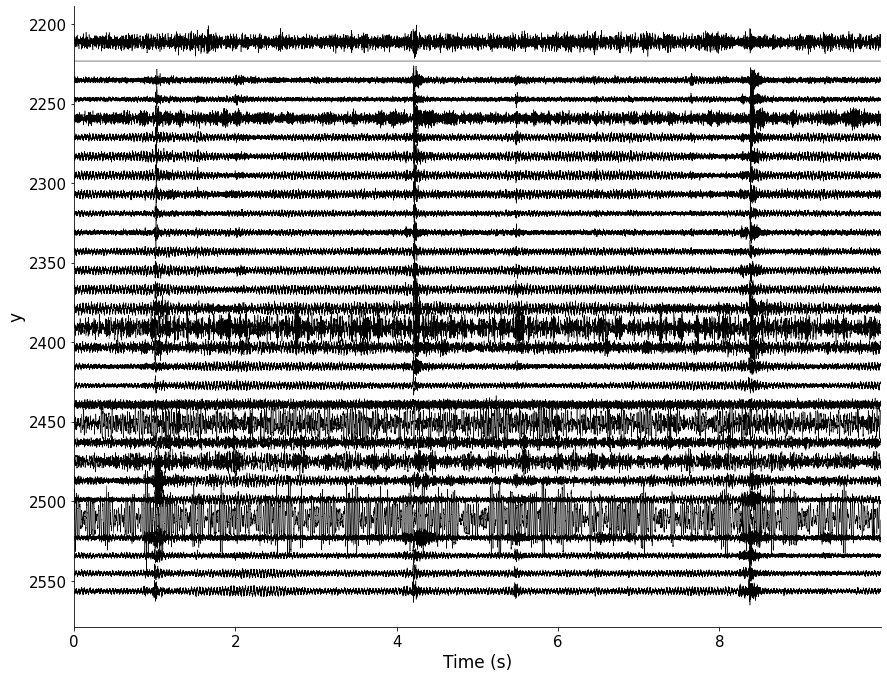

In [59]:
fname = 'File137206'
comp = 'Z'
figure = cats.plot_traces(Data, None, fname=fname, comp=comp, gain=1, alpha=0.2)
fontsize = dict(labels=17, ticks=15)
figure = figure.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=1.3, invert_yaxis=True)
figure

:Overlay
   .Curve.I      :Curve   [Time]   (y)
   .Curve.II     :Curve   [Time]   (y)
   .Curve.III    :Curve   [Time]   (y)
   .Curve.IV     :Curve   [Time]   (y)
   .Curve.V      :Curve   [Time]   (y)
   .Curve.VI     :Curve   [Time]   (y)
   .Curve.VII    :Curve   [Time]   (y)
   .Curve.VIII   :Curve   [Time]   (y)
   .Curve.IX     :Curve   [Time]   (y)
   .Curve.X      :Curve   [Time]   (y)
   .Curve.XI     :Curve   [Time]   (y)
   .Curve.XII    :Curve   [Time]   (y)
   .Curve.XIII   :Curve   [Time]   (y)
   .Curve.XIV    :Curve   [Time]   (y)
   .Curve.XV     :Curve   [Time]   (y)
   .Curve.XVI    :Curve   [Time]   (y)
   .Curve.XVII   :Curve   [Time]   (y)
   .Curve.XVIII  :Curve   [Time]   (y)
   .Curve.XIX    :Curve   [Time]   (y)
   .Curve.XX     :Curve   [Time]   (y)
   .Curve.XXI    :Curve   [Time]   (y)
   .Curve.XXII   :Curve   [Time]   (y)
   .Curve.XXIII  :Curve   [Time]   (y)
   .Curve.XXIV   :Curve   [Time]   (y)
   .Curve.XXV    :Curve   [Time]   (y)
   .Curve.XXVI   :Curve   [Time]   (y)
   .Curve.XXVII  :Curve   [Time]   (y)
   .Curve.XXVIII :Curve   [Time]   (y)
   .Curve.XXIX   :Curve   [Time]   (y)
   .Curve.XXX    :Curve   [Time]   (y)
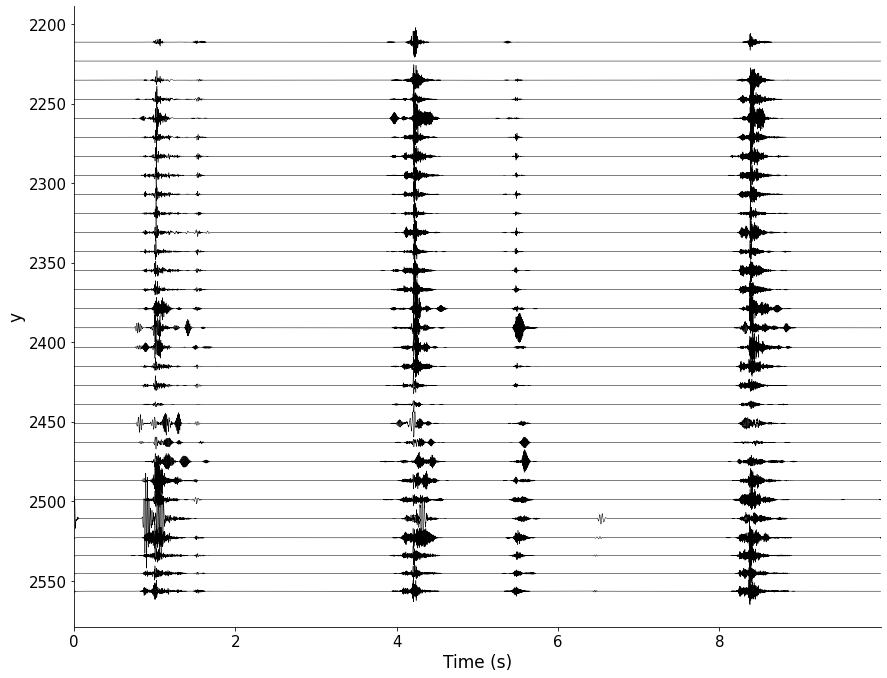

In [63]:
figure = cats.plot_traces(Denoised, None, fname=fname, comp=comp, gain=1, alpha=0.2)
figure = figure.opts(hv.opts.Curve(fontsize=fontsize), 
            hv.opts.Rectangles(fontsize=fontsize)).opts(aspect=1.3, invert_yaxis=True)
figure

# NOIZEUS voice data

In [3]:
from scipy.io import wavfile

In [4]:
folder = "C:/Users/seraf/OneDrive - ualberta.ca/Documents/NOIZEUS"
files = ["train/5dB/sp01_train_sn5", "restaurant/10dB/sp01_restaurant_sn10"]
voices = [wavfile.read(f"{folder}/{fi}.wav")[1] for fi in files]
voices = np.array(voices)
dt = 1 / 8000

In [30]:
catsden = cats.CATSDenoiser(dt_sec=dt,
                            stft_window_sec=('hann', 0.05),
                            stft_overlap=0.75,
                            stft_nfft=1024,
                            minSNR=4.0,
                            stationary_frame_sec=3.0,
                            min_dt_width_sec=0.1,
                            min_df_width_Hz=50.,
                            neighbor_distance=2,
                            min_neighbors=None,
                            date_Q=0.95,
                            date_detection_mode=False,
                            clusteringWithSNR=True,
                            wiener=False,
                            stft_backend='ssqueezepy')

In [31]:
%time denres = catsden.denoise_stepwise(voices)

CPU times: total: 62.5 ms
Wall time: 62.5 ms


:Layout
   .Curve.A_0_full_stop_Input_data_colon_x_n                                                                                                                                                                                     :Curve   [Time]   (Amplitude)
   .Image.A_1_full_stop_Spectrogram_colon_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line                                                                                                         :Image   [Time,Frequency]   (z)
   .Image.A_2_full_stop_Trimming_by_B_hyphen_minus_E_hyphen_minus_DATE_colon_B_left_curly_bracket_k_comma_m_right_curly_bracket_reverse_over_cdot_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line :Image   [Time,Frequency]   (z)
   .Image.A_3_full_stop_Clustering_colon_C_left_curly_bracket_k_comma_m_right_curly_bracket_reverse_over_cdot_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line                                     :Image   [Time,Frequency]   (z)
   .Image.A_4_full_stop_Filling_colon_F_left_curly_bracket_k_comma_m_right_curly_bracket_reverse_over_cdot_vertical_line_X_left_curly_bracket_k_comma_m_right_curly_bracket_vertical_line                                        :Image   [Time,Frequency]   (z)
   .Curve.A_5_full_stop_Denoised_signal_colon_y_n                                                                                                                                                                                :Curve   [Time]   (Amplitude)
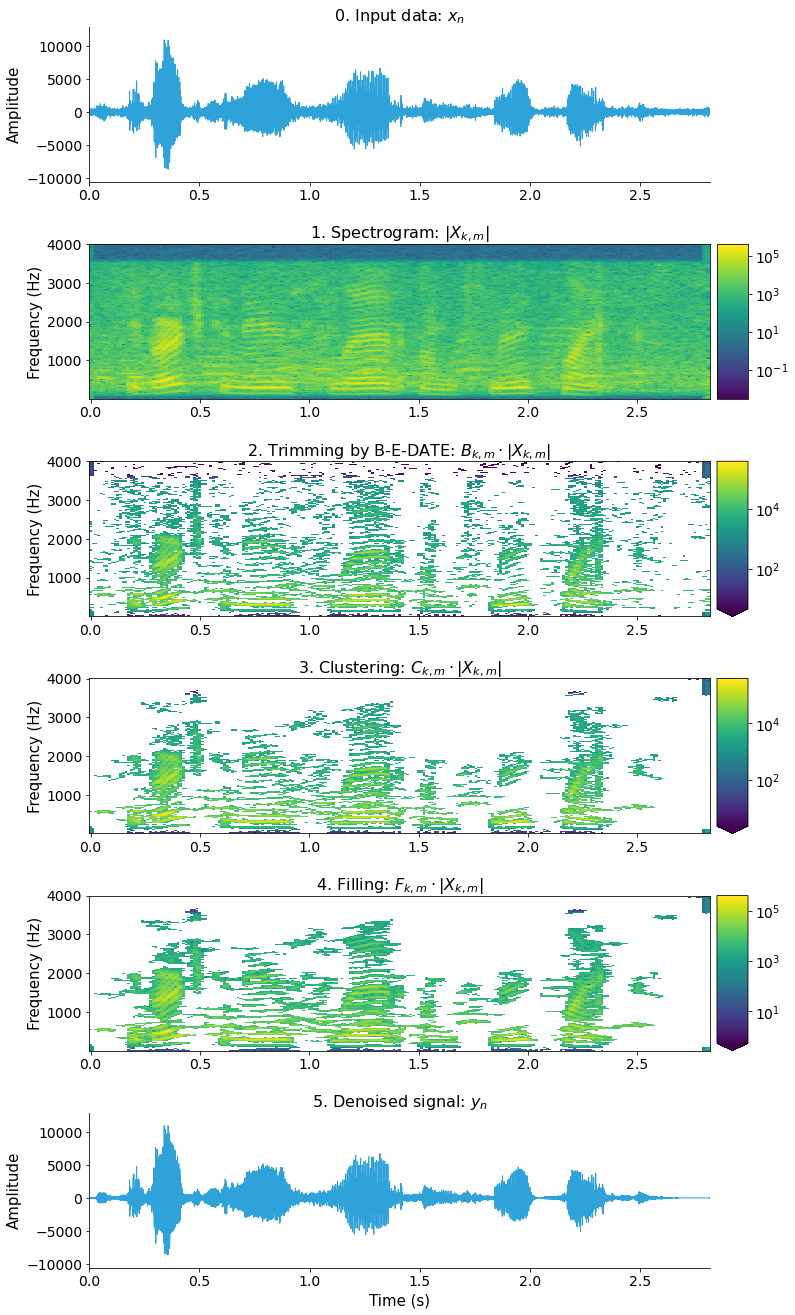

In [32]:
ind = 1
fig = denres.plot(ind)
fig.opts(hv.opts.Curve(aspect=4, linewidth=1),
         hv.opts.Image(aspect=4, logz=True, logy=False))

In [33]:
for i, fi in enumerate(files):
    wavfile.write(f"{folder}/{fi}_denoised.wav", int(1 / dt), np.int16(denres.denoised_signal[i]))